In [3]:
import h5py
import cv2
import numpy as np
from scipy import io as scio
from scipy import linalg
from scipy import signal
from scipy import sparse
from skimage.util import img_as_float
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'sklearn'

In [4]:
"""ICA
Non-contact, automated cardiac pulse measurements using video imaging and blind source separation.
Poh, M. Z., McDuff, D. J., & Picard, R. W. (2010).
Optics express, 18(10), 10762-10774. DOI: 10.1364/OE.18.010762
"""


def detrend(input_signal, lambda_value):
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = sparse.spdiags(diags_data, diags_index,
                       (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return filtered_signal

import math

import numpy as np
from scipy import linalg
from scipy import signal


def ICA_POH(frames, FS):
    # Cut off frequency.
    LPF = 0.7
    HPF = 2.5
    RGB = process_video(frames)

    NyquistF = 1 / 2 * FS
    BGRNorm = np.zeros(RGB.shape)
    Lambda = 100
    for c in range(3):
        BGRDetrend = detrend(RGB[:, c], Lambda)
        BGRNorm[:, c] = (BGRDetrend - np.mean(BGRDetrend)) / np.std(BGRDetrend)
    _, S = ica(np.mat(BGRNorm).H, 3)

    # select BVP Source
    MaxPx = np.zeros((1, 3))
    for c in range(3):
        FF = np.fft.fft(S[c, :])
        F = np.arange(0, FF.shape[1]) / FF.shape[1] * FS * 60
        FF = FF[:, 1:]
        FF = FF[0]
        N = FF.shape[0]
        Px = np.abs(FF[:math.floor(N / 2)])
        Px = np.multiply(Px, Px)
        Fx = np.arange(0, N / 2) / (N / 2) * NyquistF
        Px = Px / np.sum(Px, axis=0)
        MaxPx[0, c] = np.max(Px)
    MaxComp = np.argmax(MaxPx)
    BVP_I = S[MaxComp, :]
    B, A = signal.butter(3, [LPF / NyquistF, HPF / NyquistF], 'bandpass')
    BVP_F = signal.filtfilt(B, A, np.real(BVP_I).astype(np.double))

    BVP = BVP_F[0]
    return BVP


def process_video(frames):
    "Calculates the average value of each frame."
    RGB = []
    for frame in frames:
        sum = np.sum(np.sum(frame, axis=0), axis=0)
        RGB.append(sum / (frame.shape[0] * frame.shape[1]))
    return np.asarray(RGB)


def ica(X, Nsources, Wprev=0):
    nRows = X.shape[0]
    nCols = X.shape[1]
    if nRows > nCols:
        print(
            "Warning - The number of rows is cannot be greater than the number of columns.")
        print("Please transpose input.")

    if Nsources > min(nRows, nCols):
        Nsources = min(nRows, nCols)
        print(
            'Warning - The number of soures cannot exceed number of observation channels.')
        print('The number of sources will be reduced to the number of observation channels ', Nsources)

    Winv, Zhat = jade(X, Nsources, Wprev)
    W = np.linalg.pinv(Winv)
    return W, Zhat


def jade(X, m, Wprev):
    n = X.shape[0]
    T = X.shape[1]
    nem = m
    seuil = 1 / math.sqrt(T) / 100
    if m < n:
        D, U = np.linalg.eig(np.matmul(X, np.mat(X).H) / T)
        Diag = D
        k = np.argsort(Diag)
        pu = Diag[k]
        ibl = np.sqrt(pu[n - m:n] - np.mean(pu[0:n - m]))
        bl = np.true_divide(np.ones(m, 1), ibl)
        W = np.matmul(np.diag(bl), np.transpose(U[0:n, k[n - m:n]]))
        IW = np.matmul(U[0:n, k[n - m:n]], np.diag(ibl))
    else:
        IW = linalg.sqrtm(np.matmul(X, X.H) / T)
        W = np.linalg.inv(IW)

    Y = np.mat(np.matmul(W, X))
    R = np.matmul(Y, Y.H) / T
    C = np.matmul(Y, Y.T) / T
    Q = np.zeros((m * m * m * m, 1))
    index = 0

    for lx in range(m):
        Y1 = Y[lx, :]
        for kx in range(m):
            Yk1 = np.multiply(Y1, np.conj(Y[kx, :]))
            for jx in range(m):
                Yjk1 = np.multiply(Yk1, np.conj(Y[jx, :]))
                for ix in range(m):
                    Q[index] = np.matmul(Yjk1 / math.sqrt(T), Y[ix, :].T / math.sqrt(
                        T)) - R[ix, jx] * R[lx, kx] - R[ix, kx] * R[lx, jx] - C[ix, lx] * np.conj(C[jx, kx])
                    index += 1
    # Compute and Reshape the significant Eigen
    D, U = np.linalg.eig(Q.reshape(m * m, m * m))
    Diag = abs(D)
    K = np.argsort(Diag)
    la = Diag[K]
    M = np.zeros((m, nem * m), dtype=complex)
    Z = np.zeros(m)
    h = m * m - 1
    for u in range(0, nem * m, m):
        Z = U[:, K[h]].reshape((m, m))
        M[:, u:u + m] = la[h] * Z
        h = h - 1
    # Approximate the Diagonalization of the Eigen Matrices:
    B = np.array([[1, 0, 0], [0, 1, 1], [0, 0 - 1j, 0 + 1j]])
    Bt = np.mat(B).H

    encore = 1
    if Wprev == 0:
        V = np.eye(m).astype(complex)
    else:
        V = np.linalg.inv(Wprev)
    # Main Loop:
    while encore:
        encore = 0
        for p in range(m - 1):
            for q in range(p + 1, m):
                Ip = np.arange(p, nem * m, m)
                Iq = np.arange(q, nem * m, m)
                g = np.mat([M[p, Ip] - M[q, Iq], M[p, Iq], M[q, Ip]])
                temp1 = np.matmul(g, g.H)
                temp2 = np.matmul(B, temp1)
                temp = np.matmul(temp2, Bt)
                D, vcp = np.linalg.eig(np.real(temp))
                K = np.argsort(D)
                la = D[K]
                angles = vcp[:, K[2]]
                if angles[0, 0] < 0:
                    angles = -angles
                c = np.sqrt(0.5 + angles[0, 0] / 2)
                s = 0.5 * (angles[1, 0] - 1j * angles[2, 0]) / c

                if abs(s) > seuil:
                    encore = 1
                    pair = [p, q]
                    G = np.mat([[c, -np.conj(s)], [s, c]])  # Givens Rotation
                    V[:, pair] = np.matmul(V[:, pair], G)
                    M[pair, :] = np.matmul(G.H, M[pair, :])
                    temp1 = c * M[:, Ip] + s * M[:, Iq]
                    temp2 = -np.conj(s) * M[:, Ip] + c * M[:, Iq]
                    temp = np.concatenate((temp1, temp2), axis=1)
                    M[:, Ip] = temp1
                    M[:, Iq] = temp2

    # Whiten the Matrix
    # Estimation of the Mixing Matrix and Signal Separation
    A = np.matmul(IW, V)
    S = np.matmul(np.mat(V).H, Y)
    return A, S

In [5]:
with h5py.File(r'd:\Image Processing Course Project\UBFC-RPPG\preprocessed_data\foreheads.h5') as f:
    frames = np.array(f['subject3'])

In [8]:
yhat = ICA_POH(frames, 30)

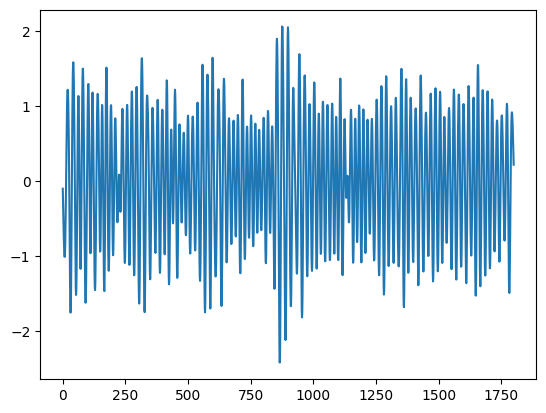

In [9]:
import matplotlib.pyplot as plt

plt.plot(yhat)

In [24]:
with open(r'D:\Image Processing Course Project\UBFC-RPPG\raw_data\subject3\ground_truth.txt', 'r') as f:
    y_raw = f.read()

In [25]:
y = np.array([float(yy.strip("'")) for yy in y_raw.split('  ')[1:]][:1000])

In [27]:
np.mean((yhat[:1000] - y) ** 2)

0.951993890697713